# TCC "Inteligência Artificial pela Segurança Jurídica"

Esse é o Google Colab Notebook que demonstra o passo a passo adotado em...


## 1º Passo: Extração dos dados com WebScraping (fora do Colab)

Vários scrapers podem funcionar aqui. Os scrapers que já fiz, incluindo o usado neste caso para o TJMG, podem ser encontrados na pasta do drive [arquivos_tcc](https://drive.google.com/drive/folders/1YOFANLHDOCSY_gZAUJThmVQHuIzhY_Fq?usp=share_link)


## 2º Passo: Tratamento, padronização e limpeza dos Dados

### 2.1:  Preparação e trazendo os dados pro Colab

Instalando as bibliotecas necessárias no ambiente:

In [ ]:
!pip install gensim==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.1-cp310-cp310-linux_x86_64.whl size=24682917 sha256=14d010e469fc8909200709858507cdc13b28463ff5ca1836682f459f4fcb381b
  Stored in directory: /root/.cache/pip/wheels/92/23/5d/b5ce54b3760acfebee170a8fe4d91cb303fafbefd8f93f3723
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.3
    Uninstalling gensim-4.3.3:
      Successfully uninstalled gensim-4.3.3


In [ ]:
!pip install pandas
!pip install scipy==1.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 766.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 26.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
!pip install nltk
!pip install unidecode
!pip install huggingface_hub
!pip install urllib3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.5 MB/s eta 0:00:00


Fazendo os imports necessários de cada biblioteca:


In [ ]:
import pandas as pd
import csv
import numpy as np

#NLTK
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk

#hugging face
from huggingface_hub import hf_hub_download
from transformers import AutoModel


# gerais
import sys
import os
from pathlib import Path
import re
from unidecode import unidecode
from pprint import pprint
from tqdm import tqdm



**OBSERVAÇÃO:** O passo abaixo chama a biblioteca gensim.models e o método KeyedVectors dela. Essa biblioteca, por sua vez, chama uma outra chamada Collections. Essa biblioteca mudou de nome para ALGUNS dos seus métodos e os caminhos foram deprecados.
Em razão disso, foi preciso alterar diretamente nos arquivos da biblioteca os imports feitos.
No lugar de
from collections import Mapping
ou
from collections import Iterable
é preciso que seja
from collections.abc import ....

Os outros métodos importados da biblioteca collections (como, por exemplo, defaultdict) vão continuar sendo importados do mesmo lugar (collections)

In [ ]:
# Gensim
from numpy import triu
import gensim.corpora as corpora
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

Começando a trazer os dados para o Colab. Fazendo a leitura do CSV e testando

In [ ]:
#definindo padrões de visualização de dados do Pandas (isso é para permitir que vejamos a string inteira e não só algumas palavras seguidas de ...)
pd.options.display.max_rows = 99999
pd.options.display.max_colwidth = 400

#recebendo o arquivo csv obtido do Scraping. Esse CSV não tem cabeçalho (por isso Header = None) e é delimitado por ; e não por ,. Isso tem que ser especificado e alterado considerando o csv usado
df = pd.read_csv('/content/direito_consumidor_tcc_ifb.csv', delimiter=";", header=None)


df.tail() #testando para ver se pegou os dados certos


0                          1                       2   \
3158  apelação cível  5002933.93.2016.8.13.0313  1.0000.20.563745-7/001   
3159  apelação cível  5081312.37.2019.8.13.0024  1.0000.20.545842-5/001   
3160  apelação cível  5174022.13.2018.8.13.0024  1.0000.19.045487-6/002   
3161  apelação cível  0033802.74.2012.8.13.0569  1.0569.12.003380-2/001   
3162  apelação cível  0145907.31.2013.8.13.0707  1.0707.13.014590-7/003   

                   3                  4           5   \
3158  Câmaras Cíveis    12ª CÂMARA CÍVEL           -   
3159  Câmaras Cíveis    15ª CÂMARA CÍVEL           -   
3160  Câmaras Cíveis    12ª CÂMARA CÍVEL           -   
3161  Câmaras Cíveis    11ª CÂMARA CÍVEL  Sacramento   
3162  Câmaras Cíveis    15ª CÂMARA CÍVEL    Varginha   

                                 6   \
3158           Habib Felippe Jabour   
3159  José Américo Martins Da Costa   
3160           Habib Felippe Jabour   
3161                 Marcos Lincoln   
3162                  Antônio Bispo   

                                                                                                                                                                               7   \
3158                                                                                                                                                NEGARAM PROVIMENTO À APELAÇÃO   
3159                                                                                                                                                NEGARAM PROVIMENTO AO RECURSO   
3160                                                                                                 NEGARAM PROVIMENTO À PRIMEIRA APELAÇÃO E DERAM PROVIMENTO À SEGUNDA APELAÇÃO   
3161                                                                                                           DAR PARCIAL PROVIMENTO AO RECURSO, NOS TERMOS DO VOTO DA .2ª VOGAL   
3162  SÚMULA: REJEITAR A PRELIMINAR DE NULIDADE DA SENTENÇA SUSCITADA PELO RELATOR. DAR PARCIAL PROVIMENTO A AMBOS OS RECURSOS, VENCIDOS PARCIALMENTE O RELATOR E O SEGUNDO VOGAL   

              8   \
3158  17/12/2020   
3159  17/12/2020   
3160  17/12/2020   
3161  11/12/2020   
3162  12/11/2020   

                                                                                     9   \
3158                             bv financeira sa credito financiamento e investimento    
3159                                                       reinaldo rodrigues dos reis    
3160   bv financeira sa credito financiamento e investimento suzely batista da fonseca    
3161                                                                   jose luiz pires    
3162                             bv financeira sa credito financiamento e investimento    

                                                                                              10  \
3158                                                                     jose pedro dos reis\n\n   
3159                                                            banco mercantil do brasil sa\n\n   
3160         bv financeira sa credito financiamento e investimento suzely batista da fonseca\n\n   
3161                      volkswagen do brasil ltda comeri litoral comercio de veiculos ltda\n\n   
3162   orosino ruella de oliveira neto bv financeira sa credito financiamento e investimento\n\n   

                                                                                                                                                                                                                                                                                                                                                                                                                   11  \
3158  EMENTA: APELAÇÃO CÍVEL - REVISÃO DE CLÁUSULAS CONTRATUAIS - CÉDULA DE CRÉDITO BANCÁRIO - FINANCIAMENTO DE AUTOMÓVEL - SEGURO PROTEÇÃO FINANCEIRA - TARIFA DE AVALIAÇÃO DO BEM - JUROS REMUNERATÓRIOS - TAXA MÉDIA DO MERCADO. O 

Dentro de todo o arquivo, o mais importante no momento é a coluna das ementas dos acórdãos. Ela está na coluna 12 da tabela e vai ser tratada como um dataframe chamado ementas:


In [ ]:
ementas = df[12]
#pegando uma única coluna do DF. A coluna que tem as ementas no caso deste CSV é a coluna 12, mas pode alterar
print(ementas.tail())


3158    apelação cível revisão de cláusulas contratuais cédula de crédito bancário financiamento de automóvel seguro proteção financeira tarifa de avaliação do bem juros remuneratórios taxa média do mercado o art 6º inciso v do código de defesa do consumidor assegura como direito básico do consumidor a modificação das cláusulas contratuais que estabeleçam prestações desproporcionais ou sua revisão em ...
3159    apelação cível direito do consumidor contratos bancários descontos indevidos violação do direito de informação do consumidor ausência de comprovação indenização danos morais requisitos não configurados 1 não é abusivo o contrato firmado entre as partes quando não resta configurada afronta os princípios consumeristas não se podendo considerar que o consumidor esteja em desvantagem exagerada ou ...
3160    apelação cível ação de procedimento comum revisão de cláusulas contratuais cédula de crédito bancário financiamento tarifa de avaliação do bem e registro de contrato seguro de 

###2.2: Removendo citações e referências

Antes mesmo de tokenizar o texto vamos retirar os trechos que estão entre parênteses e entre aspas. Normalmente os trechos entre parênteses são informações de citações ou esclarecimentos sobre siglas. Ainda, os trechos entre aspas são citações de outros precedentes ou de doutrina que só gerariam ruído ao texto.

Primeiro vamos remover os trechos com citações. Vamos retirar tudo que tiver entre aspas simples ou entre aspas duplas:

In [ ]:
def remove_citacoes(texto):
  if isinstance(texto, str): #verifica se o texto é uma string
    texto_sem_aspas_duplas = re.sub(r'"[^"]*"', '', texto)
    texto_sem_citacoes = re.sub(r"'[^']*'", "", texto_sem_aspas_duplas)
    return texto_sem_citacoes
  return texto

ementas = ementas.apply(remove_citacoes) #aplica essa função em todo DF de Ementas

print(ementas.head())

0    apelação cível embargos à execução abertura de crédito rotativo súmula 233 do stj duplicatas liquidez certeza e exigibilidade demonstrativo da dívida prosseguimento da execução honorários advocatícios extrajudiciais ilegalidade da cobrança embargos à execução acolhidos parcialmente não se desincumbido do ônus de comprovar a ilegalidade inerente à execução em trâmite bem como a inobservância do...
1    cível direito do consumidor ação de conhecimento ilegitimidade passiva teoria da asserção pretensão declaratória prescrição quinquenal descontos sobre benefício previdenciário nulidade cartão de crédito consignado negativa de contratação vício de consentimento erro substancial não verificação 1 a legitimidade refere se ao vínculo existente entre determinada parte e o resultado buscado com a aç...
2    cível direito do consumidor ação de conhecimento pretensão declaratória nulidade cartão de crédito consignado negativa de contratação vício de consentimento erro substancial não verific

Agora vamos remover os trechos entre parênteses. Normalmente entre parênteses estão as referências de um trecho citado ou a explicação de uma sigla

Ex:
(AgRg no AREsp n. 2.358.446/RS, relator Ministro Jesuíno Rissato (Desembargador Convocado do TJDFT), Sexta Turma, julgado em 27/2/2024, DJe de 4/3/2024.)

Ex: CC (Código Civil)

In [ ]:
def remove_referencias(texto):
  if isinstance(texto, str):
    texto_sem_parenteses = re.sub(r'\([^)]*\)', '', texto)
    return texto_sem_parenteses
  return texto

ementas = ementas.apply(remove_referencias) #aplica essa função em todo DF de Ementas

print(ementas.head())

0    apelação cível embargos à execução abertura de crédito rotativo súmula 233 do stj duplicatas liquidez certeza e exigibilidade demonstrativo da dívida prosseguimento da execução honorários advocatícios extrajudiciais ilegalidade da cobrança embargos à execução acolhidos parcialmente não se desincumbido do ônus de comprovar a ilegalidade inerente à execução em trâmite bem como a inobservância do...
1    cível direito do consumidor ação de conhecimento ilegitimidade passiva teoria da asserção pretensão declaratória prescrição quinquenal descontos sobre benefício previdenciário nulidade cartão de crédito consignado negativa de contratação vício de consentimento erro substancial não verificação 1 a legitimidade refere se ao vínculo existente entre determinada parte e o resultado buscado com a aç...
2    cível direito do consumidor ação de conhecimento pretensão declaratória nulidade cartão de crédito consignado negativa de contratação vício de consentimento erro substancial não verific

###2.3: Tokenizando o texto


No bloco de código abaixo vamos tokenizar as ementas que chegaram do arquivo CSV como grandes strings

In [ ]:
#from nltk.tokenize import word_tokenize
#from nltk.probability import FreqDist
nltk.download('punkt')

#tokenizando o DF ementas
ementasTokenizadas = ementas.apply(word_tokenize) #ementas é o nome do DF e ementasTokenizadas é o nome do novo DF que criamos

ementasTokenizadas.head() #todas as ementas do DF foram tokenizadas


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    [apelação, cível, embargos, à, execução, abertura, de, crédito, rotativo, súmula, 233, do, stj, duplicatas, liquidez, certeza, e, exigibilidade, demonstrativo, da, dívida, prosseguimento, da, execução, honorários, advocatícios, extrajudiciais, ilegalidade, da, cobrança, embargos, à, execução, acolhidos, parcialmente, não, se, desincumbido, do, ônus, de, comprovar, a, ilegalidade, inerente, à, ...
1    [cível, direito, do, consumidor, ação, de, conhecimento, ilegitimidade, passiva, teoria, da, asserção, pretensão, declaratória, prescrição, quinquenal, descontos, sobre, benefício, previdenciário, nulidade, cartão, de, crédito, consignado, negativa, de, contratação, vício, de, consentimento, erro, substancial, não, verificação, 1, a, legitimidade, refere, se, ao, vínculo, existente, entre, det...
2    [cível, direito, do, consumidor, ação, de, conhecimento, pretensão, declaratória, nulidade, cartão, de, crédito, consignado, negativa, de, contratação, vício, de, consentimento, erro, substancial, não, verificação, 1, a, contratação, de, cartão, de, crédito, consignado, é, autorizada, no, ordenamento, jurídico, brasileiro, o, que, não, impede, a, verificação, de, abusividades, no, caso, concre...
3    [apelação, cível, direito, do, consumidor, ação, de, conhecimento, pretensão, indenizatória, instalação, de, placas, de, energia, solar, defeito, não, comprovado, revelia, presunção, relativa, fatos, constitutivos, do, autor, ausência, de, indícios, mínimos, 1, tratando, se, de, relação, de, consumo, a, responsabilidade, do, fornecedor, é, objetiva, prescindindo, da, comprovação, de, culpa, 2,...
4    [apelação, cível, direito, do, consumidor, ação, de, conhecimento, pretensão, declaratória, nulidade, cartão, de, crédito, consignado, negativa, de, contratação, vício, de, consentimento, erro, substancial, não, verificação, 1, a, contratação, de, cartão, de, crédito, consignado, é, autorizada, no, ordenamento, jurídico, brasileiro, o, que, não, impede, a, verificação, de, abusividades, no, ca...
Name: 12, dtype: object

###2.4: Descobrindo os stopwords (opcional)

Esse passo foi feito para que descobrissemos stopwords que fossem típicos de um DF com esse tipo de texto (ementas). Vamos descobrir as palavras que mais se repetem entre os tokens. Este passo 2.2 não precisa ser feito se você já sabe seus stopwords ou se acha que eles não vão se diferenciar muito pelo contexto.

Ainda, ressalta-se que foi feita uma lista própria de stopwords que não incluísse a palavra "não" como um stopword, afinal a negativa de algo no contexto jurídico é muito relevante.


No bloco de código abaixo pegamos os textos que foram tokenizados e juntamos todos numa grande lista tokenizada também. Antes teríamos um array de arrays, agora teremos só um array com todos os tokens, misturando todas as ementas. Depois disso é feito o cálculo de frequência das palavras

In [ ]:
from nltk.probability import FreqDist

# Concatenar os textos tokenizados em uma única lista
todos_tokens_ementas = [token for sublist in ementasTokenizadas for token in sublist]

# Criar uma Frequência de Palavras
freq_dist = FreqDist(todos_tokens_ementas)

# Extrair as palavras mais comuns (as 50 mais comuns)
common_words = freq_dist.most_common(50)

print(common_words)

[('de', 41373), ('do', 32093), ('a', 24618), ('da', 15339), ('e', 13825), ('o', 13316), ('que', 10717), ('não', 8720), ('em', 8677), ('se', 7219), ('consumidor', 6546), ('por', 5545), ('direito', 5510), ('ao', 4388), ('os', 4306), ('no', 4271), ('é', 4064), ('dos', 3996), ('civil', 3819), ('apelação', 3681), ('ser', 3623), ('à', 3408), ('dano', 3332), ('na', 3303), ('ou', 3275), ('pelo', 3225), ('contrato', 3175), ('deve', 3102), ('danos', 3083), ('para', 3068), ('art', 3031), ('as', 3020), ('ação', 2989), ('código', 2985), ('cível', 2978), ('com', 2834), ('juros', 2786), ('moral', 2621), ('artigo', 2581), ('indenização', 2522), ('lei', 2516), ('morais', 2421), ('4', 2363), ('parte', 2199), ('ausência', 2047), ('1', 2032), ('nos', 2027), ('responsabilidade', 2023), ('quando', 2014), ('como', 1916)]


###2.5: Removendo os StopWords

Agora que sabemos as palavras mais repetidas dentro desse DF jurídico, podemos remover os StopWords

In [ ]:
# Ler a lista de stopwords do arquivo de texto
with open("/content/stopwords.txt", 'r') as file:
    stopwords_list = file.read().splitlines()

#criando uma função para remover os stopwords

def remove_stopwords(tokens):
  return  [token for token in tokens if token not in stopwords_list]

ementasTokenizadas = ementasTokenizadas.apply(remove_stopwords) #aplica essa função em todo DF de Ementas Tokenizadas

ementasTokenizadas.head() #mostra o novo DF de ementas Tokenizadas

0    [apelação, cível, embargos, execução, abertura, crédito, rotativo, súmula, 233, duplicatas, liquidez, certeza, exigibilidade, demonstrativo, dívida, prosseguimento, execução, honorários, advocatícios, extrajudiciais, ilegalidade, cobrança, embargos, execução, acolhidos, parcialmente, não, desincumbido, ônus, comprovar, ilegalidade, inerente, execução, trâmite, bem, inobservância, aspectos, for...
1    [cível, direito, consumidor, ação, conhecimento, ilegitimidade, passiva, teoria, asserção, pretensão, declaratória, prescrição, quinquenal, descontos, sobre, benefício, previdenciário, nulidade, cartão, crédito, consignado, negativa, contratação, vício, consentimento, erro, substancial, não, verificação, 1, legitimidade, refere, vínculo, existente, determinada, parte, resultado, buscado, ação,...
2    [cível, direito, consumidor, ação, conhecimento, pretensão, declaratória, nulidade, cartão, crédito, consignado, negativa, contratação, vício, consentimento, erro, substancial, não, verificação, 1, contratação, cartão, crédito, consignado, autorizada, ordenamento, jurídico, brasileiro, não, impede, verificação, abusividades, caso, concreto, 2, deve, declarada, nulidade, contrato, cartão, crédi...
3    [apelação, cível, direito, consumidor, ação, conhecimento, pretensão, indenizatória, instalação, placas, energia, solar, defeito, não, comprovado, revelia, presunção, relativa, fatos, constitutivos, autor, ausência, indícios, mínimos, 1, tratando, relação, consumo, responsabilidade, fornecedor, objetiva, prescindindo, comprovação, culpa, 2, 344, estabelece, caso, revelia, presumem, verdadeiros...
4    [apelação, cível, direito, consumidor, ação, conhecimento, pretensão, declaratória, nulidade, cartão, crédito, consignado, negativa, contratação, vício, consentimento, erro, substancial, não, verificação, 1, contratação, cartão, crédito, consignado, autorizada, ordenamento, jurídico, brasileiro, não, impede, verificação, abusividades, caso, concreto, 2, deve, declarada, nulidade, contrato, car...
Name: 12, dtype: object

###2.6: Removendo acentuação, caracteres especiais, números e espaços em branco (tokens vazios)

Caracteres especiais já foram removidos durante o Scraping NESTE caso, mas ainda assim será refeito para fins de reprodutibilidade científica e detalhamento da explicação


In [ ]:
import re
from unidecode import unidecode

#criando uma função para remover os acentos

def remove_acentos(tokens):
    tokens_sem_acentos = []
    padrao = r'[^a-zA-Z\s]'
    for token in tokens:
        # Remover acentos
        token = unidecode(token)
        # Manter apenas letras alfabéticas sem acentuação
        token_limpo = re.sub(padrao, '', token)
        tokens_sem_acentos.append(token_limpo)
    return tokens_sem_acentos

#criando uma função para remover os cacteres especiais

def remove_caracteres_especiais(tokens):
  tokens_sem_caracteres_especiais = []
  padrao = r'[^\w\sáéíóúàèìòùâêîôûãõçº]'
  for token in tokens:
    token_limpo = re.sub(padrao, '', token)
    tokens_sem_caracteres_especiais.append(token_limpo)
  return tokens_sem_caracteres_especiais

#criando uma função para remover os números

def remove_numeros(tokens):
  tokens_sem_numeros = []
  padrao = r'\d+'
  for token in tokens:
    token_limpo = re.sub(padrao, '', token)
    tokens_sem_numeros.append(token_limpo)
  return tokens_sem_numeros

#criando uma função para remover tokens que são espaços em branco

def remove_blanks(tokens):
  # Filtra os tokens que não são espaços em branco
    tokens_cheios = [token for token in tokens if token.strip()]
    return tokens_cheios

#aplicando as funções

ementasTokenizadas = ementasTokenizadas.apply(remove_acentos) #aplica essa função em todo DF de Ementas Tokenizadas
ementasTokenizadas = ementasTokenizadas.apply(remove_caracteres_especiais)
ementasTokenizadas = ementasTokenizadas.apply(remove_numeros)
ementasTokenizadas = ementasTokenizadas.apply(remove_blanks)


In [ ]:
ementasTokenizadas.head()

0    [apelacao, civel, embargos, execucao, abertura, credito, rotativo, sumula, duplicatas, liquidez, certeza, exigibilidade, demonstrativo, divida, prosseguimento, execucao, honorarios, advocaticios, extrajudiciais, ilegalidade, cobranca, embargos, execucao, acolhidos, parcialmente, nao, desincumbido, onus, comprovar, ilegalidade, inerente, execucao, tramite, bem, inobservancia, aspectos, formais,...
1    [civel, direito, consumidor, acao, conhecimento, ilegitimidade, passiva, teoria, assercao, pretensao, declaratoria, prescricao, quinquenal, descontos, sobre, beneficio, previdenciario, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro, substancial, nao, verificacao, legitimidade, refere, vinculo, existente, determinada, parte, resultado, buscado, acao, aj...
2    [civel, direito, consumidor, acao, conhecimento, pretensao, declaratoria, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro, substancial, nao, verificacao, contratacao, cartao, credito, consignado, autorizada, ordenamento, juridico, brasileiro, nao, impede, verificacao, abusividades, caso, concreto, deve, declarada, nulidade, contrato, cartao, credito, co...
3    [apelacao, civel, direito, consumidor, acao, conhecimento, pretensao, indenizatoria, instalacao, placas, energia, solar, defeito, nao, comprovado, revelia, presuncao, relativa, fatos, constitutivos, autor, ausencia, indicios, minimos, tratando, relacao, consumo, responsabilidade, fornecedor, objetiva, prescindindo, comprovacao, culpa, estabelece, caso, revelia, presumem, verdadeiros, fatos, af...
4    [apelacao, civel, direito, consumidor, acao, conhecimento, pretensao, declaratoria, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro, substancial, nao, verificacao, contratacao, cartao, credito, consignado, autorizada, ordenamento, juridico, brasileiro, nao, impede, verificacao, abusividades, caso, concreto, deve, declarada, nulidade, contrato, cartao, c...
Name: 12, dtype: object

###2.3: Padronizando siglas

Precisamos padronizar que as siglas usadas no texto estão sempre em sua forma completa para não serem tratadas como duas palavras

In [ ]:
import re
siglas_dict = {
    'stf': 'supremo_tribunal_federal',
    'stj': 'superior_tribunal_justiça',
    'cpc': 'codigo_processo_civil',
    'cc': 'codigo_civil',
    'cdc': 'codigo_consumidor',
    'cp': 'codigo_penal',
    'cpp': 'codigo_processo_penal',
    'cf': 'constituicao_federal',
    'tjmg': 'tribunal_justica_minas_gerais'
}

def padronizar_siglas_tokens(tokens, siglas_dict):
    # Percorrer os tokens e substituir as siglas
    tokens_padronizados = [siglas_dict[token] if token in siglas_dict else token for token in tokens]
    return tokens_padronizados


# Aplicar a função de padronização a cada texto no DataFrame
ementasTokenizadas = ementasTokenizadas.apply(lambda tokens: padronizar_siglas_tokens(tokens, siglas_dict))

print(ementasTokenizadas.head())

0    [apelacao, civel, embargos, execucao, abertura, credito, rotativo, sumula, duplicatas, liquidez, certeza, exigibilidade, demonstrativo, divida, prosseguimento, execucao, honorarios, advocaticios, extrajudiciais, ilegalidade, cobranca, embargos, execucao, acolhidos, parcialmente, nao, desincumbido, onus, comprovar, ilegalidade, inerente, execucao, tramite, bem, inobservancia, aspectos, formais,...
1    [civel, direito, consumidor, acao, conhecimento, ilegitimidade, passiva, teoria, assercao, pretensao, declaratoria, prescricao, quinquenal, descontos, sobre, beneficio, previdenciario, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro, substancial, nao, verificacao, legitimidade, refere, vinculo, existente, determinada, parte, resultado, buscado, acao, aj...
2    [civel, direito, consumidor, acao, conhecimento, pretensao, declaratoria, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro, substancial, nao, ver

###2.7: Salvando o novo DF limpo


In [ ]:
#salvar esse df já limpo para um CSV

ementasTokenizadas.to_csv('/content/direito_consumidor_limpo.csv', index=False)

Se você já tem um arquivo CSV limpo, é possível recomeçar a partir desse código aqui, em que o csv certo, já normalizado, é carregado para a mesma variável que vamos usar para as próximas análises

In [ ]:
import pandas as pd
ementasTokenizadas = pd.read_csv('/content/direito_consumidor_limpo.csv', delimiter=";", header=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##3º Passo: Word Embeddings

Esse passo transforma palavras em números reais de dimensão fixa, algo com qual o computador possa trabalhar. Esse tipo de representação colcoa palavras semanticamente semelhantes com representação vetorial próxima. Esse passo que permitirá a observação de relações emânticas e contextuais entre as palavras.

WordEmbedding é o resultado de palavras passando por uma rede neural. Alguém já fez isso? Já. Quando isso já foi feito se guarda dentro do que chamamos de modelo em que cada palavra já tem seu número certo


###3.1 Usando o modelo Projeto LegalNLP

Criar o próprio modelo  é muito trabalho e precisa de muitos dados. Vamos usar o modelo do Projeto LegalNLP e ver os resultados: https://huggingface.co/Projeto/LegalNLP

O modelo escolhido foi considerado por ter em sua base de dados processos de tribunais estaduais, focado no tribunal de São Paulo. Isso torna a base de treinamento mais próxima dos dados em que vamos aplicar o modelo (decisões do TJMG)

Existem duas arquiteturas de modelo Word2Vec:

**-> CBOW (Continuous Bag of Words):** tem como objetivo prever a palavra alvo (central) dado o contexto (palavras vizinhas). Seu uso é recomendado para quando o contexto em torno das palavras é relativamente estável e não muito grande. É mais rápido para treinar e costuma ser eficaz em conjuntos de dados grandes.

**-> SG (Skip-gram):** Tenta prever o contexto (palavras vizinhas) dado a palavra alvo (central). É adequado para conjuntos de dados menores ou com vocabulário complexo, onde a relação entre palavras pode ser mais variável. Pode capturar melhor relações semânticas complexas.

Em razão disso, **o modelo escolhido foi o da arquitetura Skip-gram**

Dentre os parâmetros do modelo, escolhemos um **size de 200, windows 15 e epochs 20.**

Size (size):
size se refere à dimensão dos vetores de palavra (word vectors) que o modelo Word2Vec aprende para representar palavras. Em outras palavras, define o tamanho do espaço vetorial em que as palavras serão mapeadas. Por exemplo, se size=100, cada palavra será representada por um vetor de 100 dimensões.

Window (window):
window especifica o tamanho da janela de contexto ao redor de cada palavra durante o treinamento do modelo. O Word2Vec usa o contexto das palavras próximas para aprender as representações vetoriais. window define quantas palavras antes e depois da palavra alvo serão consideradas como contexto para prever a palavra alvo. Por exemplo, se window=5, o modelo considera 5 palavras antes e 5 palavras depois da palavra alvo em cada sentença durante o treinamento.

Epochs (epochs):
epochs indica o número de iterações (ou passagens) completas pelos dados de treinamento durante o treinamento do modelo. Cada época é composta por várias iterações, onde o modelo atualiza os pesos das palavras para melhorar a precisão das previsões. Mais épocas podem melhorar a precisão do modelo, mas também aumentam o tempo de treinamento.

In [ ]:
from huggingface_hub import hf_hub_download
from transformers import AutoModel
from gensim.models import KeyedVectors
#from legalnlp.get_premodel import get_premodel


w2v_sg_d2v_dbow = hf_hub_download(repo_id = "Projeto/LegalNLP", filename = "w2v_d2v_dbow_size_100_window_15_epochs_20")
w2v_cbow_d2v_dm = hf_hub_download(repo_id = "Projeto/LegalNLP", filename = "w2v_d2v_dm_size_100_window_15_epochs_20")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)2v_d2v_dbow_size_100_window_15_epochs_20:   0%|          | 0.00/130M [00:00<?, ?B/s]

w2v_d2v_dm_size_100_window_15_epochs_20:   0%|          | 0.00/130M [00:00<?, ?B/s]



Por fim, o código abaixo carrega o modelo LegalNLP

In [ ]:
#from gensim.models import KeyedVectors
# eu tive que alterar todas as importações do Collections. Agora Iterable e Mapping vem da collections.abc (link: https://github.com/Kyubyong/wordvectors/issues/28)

# o modelo pode ser encontrado no drive do projeto google NLP (https://huggingface.co/Projeto/LegalNLP#2)

#Carregando o modelo W2Vec. O nome do modelo ficou definido como w2v

#model=KeyedVectors.load(w2v_sg_d2v_dbow) puxa o modelo de size 100

model = Word2Vec.load('/content/model/w2v_d2v_dbow_size_200_window_15_epochs_20.bin')
w2v=model.wv


Abaixo testamos algumas características do modelo

In [ ]:
#Mostra os embbeds da palavra juiz
w2v['juiz'][:10]

array([-0.18801059,  0.6928802 ,  0.12818356, -0.43818572,  0.03646956,
        0.14361778,  0.1314593 ,  0.39880392,  0.14501512,  0.36494234],
      dtype=float32)

In [ ]:
#Mostra as 10 palavras mais similares a 'apelo'
w2v.most_similar('apelo')

[('recurso', 0.809807300567627),
 ('apelos', 0.7133127450942993),
 ('apelo_patronal', 0.6912683248519897),
 ('interposto', 0.6810765266418457),
 ('parcial_provimento', 0.6721136569976807),
 ('recurso_adesivo', 0.66606605052948),
 ('adesivo', 0.6512070894241333),
 ('improvimento', 0.6485990285873413),
 ('reformar', 0.6483910083770752),
 ('merece', 0.6457449197769165)]

###3.2 n-gramas


Com o modelo em mãos, ainda falta uma outra etapa de pré processamento dos textos.

Existem palavras que não fazem sentido sozinhas, mas são verdadeiras expressões. Dentro do contexto do direito, podemos pensar que "código civil" não faz sentido em ser tratado como duas palavras separadas, mas como uma só, como "código_civil".

O modelo que estamos usando já possui alguns n-gramas em seu vocabulário. Vamos verificar quais são

In [ ]:
# Obter o vocabulário do modelo
vocab = list(w2v.vocab.keys())

# Filtrar e exibir n-gramas (neste caso, bigramas e trigramas são detectados pela presença de '_')
n_grams = [word for word in vocab if '_' in word]

n_grams = [unidecode(n_gram) for n_gram in n_grams]

# Exibir os 100 primeiros n-gramas
print(n_grams[100:150])



['participante_efetuar_alguma_intervencao', 'deverao_acessar', 'minutos_antes', 'horario_designado', 'ali_permanecer_aguardando', 'atrasos_podem_ocorrer', 'ter_sido_encerrada', 'e_criado_especificamente', 'efetiva_identificacao', 'autorizacao_previa', 'participante_recebera_uma', 'meio_eletronico', 'participante_podera', 'acessar_livremente', 'trabalhos_sejam_facilitados', 'qual_possamos_entrar', 'advogados_comunicar_diretamente', 'aos_respectivos_clientes', 'nesse_periodo', 'surgem_dificuldades', 'solicita-se_especial_empenho', 'empreendam_esforcos', 'solucao_negociada', 'serao_inquiridas_testemunhas', 'rio_preto', 'rodrigo_fernando_sanita', 'wilson_sales_belchior', 'procedimento_comum_civel', 'dano_material', 'banco_santander', 'auto_pecas', 'tramitar_eletronicamente', 'sistema_eproc', 'santa_catarina', 'resolucao_conjunta_gp', 'cgj_n', 'passando_sua_tramitacao', 'reger-se_pelas_normas_dessa', 'ficam_intimados', 'validacao_cadastral', 'conforme_inciso_iv', 'cons_civeis_comerciais', '

Agora vamos encontrar quais desses n-gramas do modelo estão na base de dados que estamos usando

In [ ]:
def encontra_n_grams(tokens, model, vocab, max_n=4):
    n = len(tokens)
    new_tokens = tokens[:]  # Evita criar uma nova cópia se não for necessário modificar diretamente

    #vocab_set = set(vocab)  # Converte vocab para um conjunto para busca rápida

    for i in range(n):
        for j in range(2, min(max_n+1, n-i+1)):  # Evita loops desnecessários
            ngram = '_'.join(tokens[i:i+j])
            if ngram in vocab_set:
                new_tokens[i:i+j] = [ngram] + [''] * (j - 1)

    # Remover tokens vazios
    new_tokens = [token for token in new_tokens if token]
    return new_tokens

vocab = list(w2v.vocab.keys())
vocab_set = set(vocab)  # Converte vocab para um conjunto para busca rápida
# Aplicar a função em todas as linhas do DataFrame
ementasTokenizadas = ementasTokenizadas.apply(lambda tokens: encontra_n_grams(tokens, w2v, vocab_set))

# Exibir o DataFrame resultante
print(ementasTokenizadas.head())

0    [apelacao_civel, embargos, execucao, abertura, credito, rotativo, sumula, duplicatas, liquidez, certeza, exigibilidade, demonstrativo, divida, prosseguimento, execucao, honorarios, advocaticios, extrajudiciais, ilegalidade, cobranca, embargos, execucao, acolhidos_parcialmente, nao, desincumbido, onus, comprovar, ilegalidade, inerente, execucao, tramite, bem, inobservancia, aspectos_formais, co...
1    [civel, direito, consumidor, acao, conhecimento, ilegitimidade_passiva, teoria, assercao, pretensao, declaratoria, prescricao, quinquenal, descontos, sobre, beneficio, previdenciario, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro_substancial, nao, verificacao, legitimidade, refere, vinculo, existente, determinada, parte, resultado, buscado, acao, ajui...
2    [civel, direito, consumidor, acao, conhecimento, pretensao, declaratoria, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro_substancial, nao, veri

Esse modelo não tem todos os n_gramas que são úteis, então vamos adicionar novos n_gramas de uma lista personalizada

In [ ]:
# Ler a lista de ngramas do arquivo de texto
with open("/content/n_grams.txt", 'r') as file:
    n_grams_list = file.read().splitlines()

#criando uma função para identificar n_gramas personalizados
def novos_n_gramas(tokens, n_grams_list, max_n=3):
    n = len(tokens)
    new_tokens = tokens[:]  # Evita criar uma nova cópia se não for necessário modificar diretamente

    for i in range(n):
        for j in range(2, min(max_n+1, n-i+1)):
            ngram = '_'.join(tokens[i:i+j])
            if ngram in n_grams_list:
                new_tokens[i:i+j] = [ngram] + [''] * (j - 1)

    # Remover tokens vazios
    new_tokens = [token for token in new_tokens if token]
    return new_tokens

# Aplicar a função em todas as linhas do DataFrame
ementasTokenizadas = ementasTokenizadas.apply(lambda tokens: novos_n_gramas(tokens, n_grams_list))

# Exibir o DataFrame resultante
print(ementasTokenizadas.head())

0    [apelacao_civel, embargos_execucao, abertura, credito_rotativo, sumula, duplicatas, liquidez, certeza, exigibilidade, demonstrativo, divida, prosseguimento, execucao, honorarios, advocaticios, extrajudiciais, ilegalidade, cobranca, embargos_execucao, acolhidos_parcialmente, nao, desincumbido, onus, comprovar, ilegalidade, inerente, execucao, tramite, bem, inobservancia, aspectos_formais, const...
1    [civel, direito_consumidor, acao_conhecimento, ilegitimidade_passiva, teoria_assercao, pretensao_declaratoria, prescricao_quinquenal, descontos, sobre, beneficio, previdenciario, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro_substancial, nao_verificacao, legitimidade, refere, vinculo, existente, determinada, parte, resultado, buscado, acao, ajuizada, ...
2    [civel, direito_consumidor, acao_conhecimento, pretensao_declaratoria, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro_substancial, nao_verifica

##4º Passo: Análise de Similaridade Semântica

O modelo já é capaz de calcular similaridade entre palavras, mas precisamos que ele calcule a similaridade de textos.


São formas de calcular similaridade

Similaridade de Cosseno: Mede o cosseno do ângulo entre dois vetores de representação de texto. É uma medida comumente usada em modelos de word embeddings, onde cada texto é representado como um vetor no espaço vetorial. Quanto mais próximo o valor do cosseno for de 1, mais similares são os textos.

Distância Euclidiana: Calcula a distância entre dois pontos no espaço vetorial. Em contextos de word embeddings, isso pode ser feito subtraindo um vetor do outro e calculando a magnitude do vetor resultante. Textos mais semelhantes terão uma distância euclidiana menor.

Distância de Jaccard: Calcula a similaridade entre dois conjuntos de palavras dividindo o tamanho da interseção pelo tamanho da união dos conjuntos. É útil para medir a sobreposição de palavras entre dois textos.

Similaridade semântica baseada em Ontologias: Mede a similaridade entre dois textos com base na semântica das palavras e suas relações em uma ontologia, como WordNet. Por exemplo, dois textos que compartilham muitas palavras sinônimas ou hiperônimas podem ser considerados mais similares.


###4.1 Calculando a Similaridade de Textos com Soft Cosseno e LegalNLP


Para calcular similaridade seguimos os seguintes passos:

1. Fazer um Dicionário
2. Representar os documentos a serem analisados no formato BoW
3. Representar os documentos a serem analisados no formato TFIDF
4. Calcular o índice de similaridade entre os termos
5. Fazer a matriz de similaridade entre os termos
6. Calcular o índice de similaridade entre os documentos
7. Fazer a matriz de similaridade entre os documentos

####4.1.1 Dicionário


No trecho de código abaixo, todo o DataFrame de ementasTokenizadas é colocada pelo método Dictionary da gensim.corpora. Isso encapsula as palavras únicas que tem no DF.

In [ ]:
from gensim.corpora import Dictionary

dictionary = Dictionary(ementasTokenizadas)

print(dictionary)

Dictionary(12264 unique tokens: ['abertura', 'abusividade', 'acolhidos_parcialmente', 'advocaticios', 'apelacao_civel']...)


####4.1.2 Representação BOW

In [ ]:
# Converta suas ementas para o formato bag-of-words
ementasTokenizadasBoW = [dictionary.doc2bow(ementa) for ementa in ementasTokenizadas] #gera um corpus BoW

#acima é a mesma coisa que criar uma lista vazia, fazer um for sobre cada uma das ementas e depois um append na nova lista

print(ementasTokenizadas.head())
print(ementasTokenizadasBoW)

0    [apelacao_civel, embargos_execucao, abertura, credito_rotativo, sumula, duplicatas, liquidez, certeza, exigibilidade, demonstrativo, divida, prosseguimento, execucao, honorarios, advocaticios, extrajudiciais, ilegalidade, cobranca, embargos_execucao, acolhidos_parcialmente, nao, desincumbido, onus, comprovar, ilegalidade, inerente, execucao, tramite, bem, inobservancia, aspectos_formais, const...
1    [civel, direito_consumidor, acao_conhecimento, ilegitimidade_passiva, teoria_assercao, pretensao_declaratoria, prescricao_quinquenal, descontos, sobre, beneficio, previdenciario, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro_substancial, nao_verificacao, legitimidade, refere, vinculo, existente, determinada, parte, resultado, buscado, acao, ajuizada, ...
2    [civel, direito_consumidor, acao_conhecimento, pretensao_declaratoria, nulidade, cartao, credito, consignado, negativa, contratacao, vicio, consentimento, erro_substancial, nao_verifica

####4.1.3 Representação TFIDF

In [ ]:
from gensim.models import TfidfModel

ementasTokenizadastfidf = TfidfModel(ementasTokenizadasBoW) #o método TfidfModel recebe um corpus já passado pelo BOW? Sim, passar o corpus pela função de Bag of Words (BoW) antes de usar o TF-IDF é um passo necessário porque o modelo TF-IDF trabalha com a frequência das palavras nos documentos. A técnica BoW converte o texto em uma forma que representa essas frequências de maneira estruturada

#Ao passar o corpus pela etapa BoW, você está preparando os dados na forma necessária para que o modelo TF-IDF possa calcular as frequências relativas e raridade das palavras corretamente.

print(ementasTokenizadastfidf)

TfidfModel(num_docs=3163, num_nnz=302088)


####4.1.4 Índice de Similaridade entre Termos

A função WordEmbeddingSimilarityIndex compara documentos ou palavras com base em seus vetores de embeddings. OU SEJA, tá usando o modelo LegalNLP que baixamos em cima

O índice de similaridade é uma estrutura que facilita o cálculo da similaridade. É usado como base para calcular a similaridade  na matriz

In [ ]:
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix

#essa linha instancia um objeto dessa classe utilizando o modelo w2v
termsim_index = WordEmbeddingSimilarityIndex(w2v)

print(termsim_index)

####4.1.5 Matriz de Similaridade entre Termos

A função SparseTermSimilarityMatrix da biblioteca gensim cria uma matriz esparsa de similaridade **entre termos** (palavras) de um corpus, utilizando um índice de similaridade de embeddings de palavras (termsim_index). Essa matriz captura a similaridade semântica entre termos, possibilitando cálculos de similaridade entre documentos que consideram não apenas a presença de palavras exatas, mas também as relações semânticas entre essas palavras.

A linha de código abaixo cria a matriz de similaridade. A matriz de similaridade é uma estrutura matemática em que cada entrada é comparada com todas as outras. **A matriz termsim_matrix armazena as similaridades entre todos os pares de termos no vocabulário.** Isso será importante quando formos analisar similaridade dos documentos.

OBS: O último parâmetro, aqui passado como *ementasTokenizadastfidf* é opcional. Ele faz com que as colunas da matriz de similaridade sejam construídas em ordem decrescente de importância dos termos por causa do cálculo de tfidf


In [ ]:
termsim_matrix = SparseTermSimilarityMatrix(source=termsim_index, dictionary=dictionary,  tfidf=ementasTokenizadastfidf)

Depois de feita a Matriz de Similaridade de TERMOS com o método SparseTermSimilarityMatrix é possível utilizar esa matriz para calcular a similaridade entre documentos. Isso é feito pelo método SoftCosineSimilarity (ou outros que a biblioteca permite)

Calcular a similaridade entre os TERMOS antes é importante para que não seja calculada a similaridade do documento considerando somente palavras iguais, mas também palavras sinônimas ou muito próximas também tem que ser levadas em consideração no cálculo.

A classe SoftCosineSimilarity do Gensim calcula a similaridade entre documentos usando uma métrica chamada "Soft Cosine". Ao contrário da similaridade de cosseno tradicional, que apenas considera a presença ou ausência de termos comuns, a "Soft Cosine" também leva em conta a similaridade semântica entre termos diferentes.



####4.1.6 Índice de Similaridade entre Documentos

Assim como criamos um índice de similaridade entre os termos, agora vamos criar um índice de similaridade entre os documentos. Esse índice vai armazenar informações sobre a similaridade dos elementos para permitir uma comparação eficiente

Para calcular a similaridade entre dois documentos, o índice usa a matriz de similaridade de termos para considerar não apenas a presença dos mesmos termos em ambos os documentos, mas também a similaridade entre **termos diferentes.**

In [ ]:
from gensim.similarities import SoftCosineSimilarity


# CÁLCULO DA SIMILARIDADE POR SOFTCOSSENO
#docsim_index é um objeto. É uma instância da Classe SoftCosineSimilarity
docsim_index = SoftCosineSimilarity(ementasTokenizadasBoW, termsim_matrix)


####4.1.7 Matriz de Similaridade entre Documentos

In [ ]:
# TODOS PARA TODOS. SIMILARIDADE ENTRE DOCUMENTOS
#aqui estou passando uma lista inteira de documentos BoW para esse objeto docsim_index. Daí ele calculará a similaridade de todos da lista vs todos da lista
similarity_matrix = docsim_index[ementasTokenizadasBoW]

print(similarity_matrix)

[[1.         0.21916682 0.19505608 ... 0.27398297 0.16749932 0.25274026]
 [0.2191668  1.         0.9472992  ... 0.35481238 0.25188908 0.28343862]
 [0.19505607 0.9472994  1.         ... 0.3158078  0.19949402 0.25672337]
 ...
 [0.27398297 0.35481235 0.31580782 ... 1.         0.2092145  0.5842776 ]
 [0.1674993  0.25188908 0.19949403 ... 0.20921452 1.         0.25688675]
 [0.25274023 0.28343862 0.25672328 ... 0.5842777  0.25688675 1.        ]]


In [ ]:
matriz_similaridade = pd.DataFrame(similarity_matrix)
matriz_similaridade.to_csv('/content/similarity_matrix.csv', index=False)

##### 4.1.7.1 Remoção de "outliers" (opcional)

Removendo documentos que não sejam parecidos com nenhum outro documento. Se o documento não tiver uma similaridade acima de 80% com nenhum dos outros, deve ser removido

In [ ]:
limiar_similaridade = 0.8

# Calcula a similaridade máxima de cada documento com todos os outros documentos
max_similarities = np.max(similarity_matrix - np.eye(similarity_matrix.shape[0]), axis=1)

# Identifica os índices dos documentos que têm pelo menos uma similaridade maior que X
indices_manter = np.where(max_similarities >= limiar_similaridade)[0]

# Filtra a similarity_matrix para manter apenas os documentos que atendem ao critério
similarity_matrix_filtrada = similarity_matrix[indices_manter][:, indices_manter]

# Exemplo de saída dos documentos que atendem ao critério
novas_ementas = []
print("Documentos filtrados:")
for i in indices_manter:
    print(i, ementas[i])
    novas_ementas.append(ementas[i])

print(len(novas_ementas))

df_filtrado = pd.DataFrame(novas_ementas)
df_filtrado.to_csv('dados_filtrados.csv', index=False)

#  saída da matriz de similaridade filtrada
print("\nMatriz de Similaridade sem outliers:")
print(similarity_matrix_filtrada)

similarity_matrix = similarity_matrix_filtrada
print(similarity_matrix)


Documentos filtrados:
6 direito do consumidor civil e processual civil apelação cível relação de consumo suspensão indevida de sinal de televisão via satélite conversão da obrigação de fazer em perdas e danos possibilidade dano moral indenização quantum majoração honorários advocatícios percentual elevação sentença reformada em parte recurso provido parcialmente mostrando se de impossível cumprimento a obrigação de fazer determinada initio litis é viável a conversão em perdas e danos a teor do que estabelece o artigo 499 do cpc a indenização por lesão moral deve ser fixada em observância aos princípios da razoabilidade e proporcionalidade segundo as peculiaridades do caso levando se em conta a extensão do dano nos feitos em que houver condenação os honorários advocatícios serão fixados entre o mínimo de 10 dez por cento e o máximo de 20 vinte por cento dessa base de cálculo
7 direito do consumidor civil e processual civil apelação cível relação de consumo suspensão indevida de sinal de

### 4.2 K-Means

Depois de calcular a similaridade entre documentos, usa-se kmeans para agrupar esses documentos similares em clusters. Essa etapa facilita a interpretação dos dados, permitindo a observação de similaridade, identificação de padrões e tendências de uma forma com menos dimensões

#### 4.2.1 Redução de dimensionalidade

Antes de aplicar K-means é preciso reduzir a dimensionalidade dos dados que estamos lidando, pois são vetores de características com muitas dimensões.

Reduzir a dimensionalidade é também ajudar na melhoria do desempenho computacional, permitir a visualização e mitigar a "Maldição da Dimensionalidade"*.

Maldição da Dimensionalidade é um situação que ocorre quando lidando com vetores com muitas dimensões. Em alta dimensionalidade, as distâncias entre pontos se tornam menos discriminativas (todos os pontos tendem a ficar equidistantes uns dos outros). A redução da dimensionalidade ajuda a mitigar esse problema, tornando as distâncias mais significativas.

Existem algumas formas de reduzir a dimensionalidade, sendo os mais comuns


*   PCA (Principal Component Analysis)
*   t-SNE (t-Distributed Stochastic Neighbor Embedding)
*   LDA (Linear Discriminant Analysis)



##### 4.2.1.1 PCA

In [ ]:
# REDUÇÃO DA DIMENSIONALIDADE POR PCA
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


pca = PCA(n_components=2)

pca_reduced_similarity_matrix = pca.fit_transform(similarity_matrix) # nao suporta dados esparsos. A gente tinha o resultado de uma SparseMatrix

#T-sne
#clusterização por kmeans
kmeans = KMeans(n_clusters = 4, n_init=10)

label_line = kmeans.fit_predict(pca_reduced_similarity_matrix)

# Obter os rótulos dos clusters
unique_labels_line = np.unique(label_line)



##### 4.2.1.2 t-SNE

In [ ]:
from sklearn.manifold import TSNE

# Reduzir a dimensionalidade usando t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_reduced_similarity_matrix = tsne.fit_transform(similarity_matrix)

##### 4.2.1.3 LDA

In [ ]:
from gensim import models

# Treinar um modelo LDA
num_topics = 2
lda = models.LdaModel(ementasTokenizadasBoW, num_topics=num_topics, id2word=dictionary, passes=15)

# Representar cada documento pelas distribuições de tópico
lda_corpus = lda[ementasTokenizadasBoW]
lda_reduced_similarity_matrix = np.array([[dict(doc).get(i, 0) for i in range(num_topics)] for doc in lda_corpus])

#### 4.2.2 Métricas de Validação Interna do K-Means


##### 4.2.2.1 Elbow Method

Elbow Method na Matriz de Similaridade reduzida por PCA

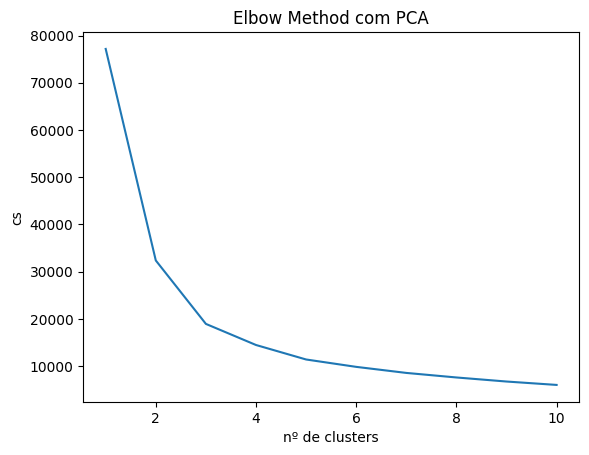

In [ ]:
#elbow method
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


cs = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state =0)
  kmeans.fit(pca_reduced_similarity_matrix) # ESCOLHER UM DATAFRAME GERADO PELOS CÁLCULOS DE DIST NCIA: df_adj_binary_similarity, df_jaccard, df_adj_binary_sim_cols, df_jaccard_cols
  cs.append(kmeans.inertia_)

plt.plot(range(1,11), cs)
plt.title('Elbow Method com PCA')
plt.xlabel('nº de clusters')
plt.ylabel('cs')
plt.show()

Elbow Method na Matriz de Similaridade reduzida por t-SNE

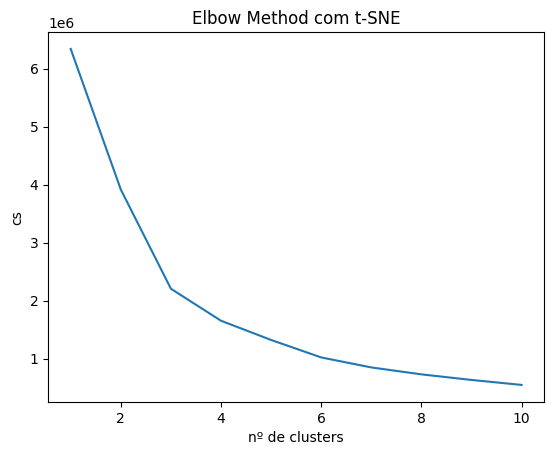

In [ ]:
#elbow method
#import matplotlib as plt
#import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans

cs = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state =0)
  kmeans.fit(tsne_reduced_similarity_matrix) # ESCOLHER UM DATAFRAME GERADO PELOS CÁLCULOS DE DIST NCIA: df_adj_binary_similarity, df_jaccard, df_adj_binary_sim_cols, df_jaccard_cols
  cs.append(kmeans.inertia_)

plt.plot(range(1,11), cs)
plt.title('Elbow Method com t-SNE')
plt.xlabel('nº de clusters')
plt.ylabel('cs')
plt.show()

Elbow Method na Matriz de Similaridade reduzida por LDA

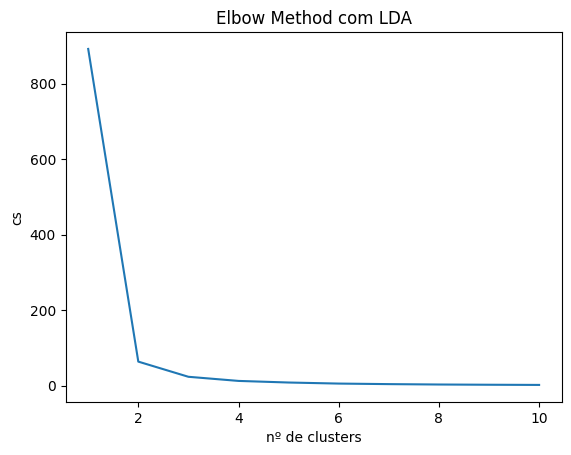

In [ ]:
#elbow method
#import matplotlib as plt
#import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans

cs = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state =0)
  kmeans.fit(lda_reduced_similarity_matrix) # ESCOLHER UM DATAFRAME GERADO PELOS CÁLCULOS DE DIST NCIA: df_adj_binary_similarity, df_jaccard, df_adj_binary_sim_cols, df_jaccard_cols
  cs.append(kmeans.inertia_)

plt.plot(range(1,11), cs)
plt.title('Elbow Method com LDA')
plt.xlabel('nº de clusters')
plt.ylabel('cs')
plt.show()

##### 4.2.2.2 Coeficiente de Silhouette

é uma métrica interna de validação dos clusters gerados. O Coeficiente vai de -1 até 1. Diz-se que a clusterização foi boa se o coeficiente é positivo, mas melhor quanto mais próximo de 1

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

# Unir os tokens de cada documento em uma única string
ementasTokenizadas_concatenadas = [' '.join(doc) for doc in ementasTokenizadas]


#Cria instância do objeto vetorizador
vectorizer = TfidfVectorizer()

ementasvetorizadas_tfidf = vectorizer.fit_transform(ementasTokenizadas_concatenadas)

# Predições dos clusters para os dados
labels = kmeans.labels_

# Calcular coeficiente de silhueta com TF-IDF
silhouette_avg_tfidf = silhouette_score(ementasvetorizadas_tfidf, labels)
print("Coeficiente de Silhueta (TF-IDF):", silhouette_avg_tfidf)

Coeficiente de Silhueta (TF-IDF): 0.01429237467183379


É possível descobrir a quantidade adequada de clusters fazendo uma curva do coeficiente de silhouette, em que ele é testado para vários números de clusters. (ex: 1 cluster o coeficiente é x, 2 clusters é y...)



Coeficiente de Silhouette com PCA

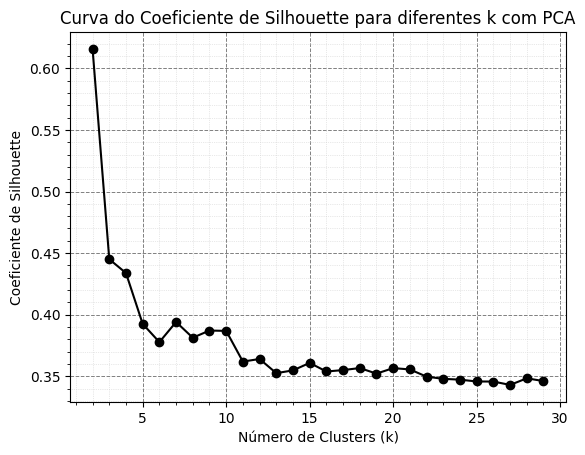

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calcular o coeficiente de Silhouette para diferentes números de clusters
silhouette_scores = []
k_values = range(2, 30)  # Intervalo de k para testar

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(pca_reduced_similarity_matrix)
    score = silhouette_score(pca_reduced_similarity_matrix, clusters)
    silhouette_scores.append(score)

# Plotar a curva do coeficiente de Silhouette

plt.plot(k_values, silhouette_scores, marker='o', color='black')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Curva do Coeficiente de Silhouette para diferentes k com PCA')
plt.grid(True, which='major', linestyle='--', linewidth=0.7, color='grey')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
plt.show()

Coeficiente de Silhouette com t-SNE

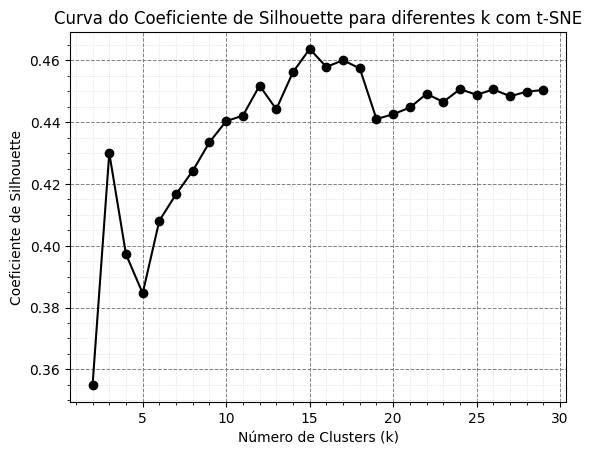

In [ ]:


# Calcular o coeficiente de Silhouette para diferentes números de clusters
silhouette_scores = []
k_values = range(2, 30)  # Intervalo de k para testar

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(tsne_reduced_similarity_matrix)
    score = silhouette_score(tsne_reduced_similarity_matrix, clusters)
    silhouette_scores.append(score)

# Plotar a curva do coeficiente de Silhouette

plt.plot(k_values, silhouette_scores, marker='o', color='black')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Curva do Coeficiente de Silhouette para diferentes k com t-SNE')
plt.grid(True, which='major', linestyle='--', linewidth=0.7, color='grey')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
plt.show()

Coeficiente de Silhouette com LDA

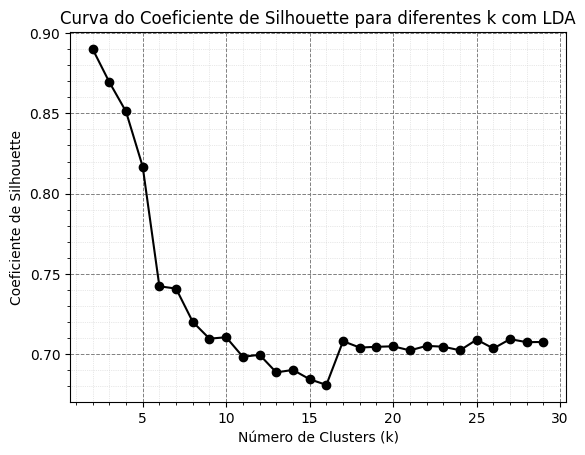

In [ ]:


# Calcular o coeficiente de Silhouette para diferentes números de clusters
silhouette_scores = []
k_values = range(2, 30)  # Intervalo de k para testar

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(lda_reduced_similarity_matrix)
    score = silhouette_score(lda_reduced_similarity_matrix, clusters)
    silhouette_scores.append(score)

# Plotar a curva do coeficiente de Silhouette

plt.plot(k_values, silhouette_scores, marker='o', color='black')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Curva do Coeficiente de Silhouette para diferentes k com LDA')
plt.grid(True, which='major', linestyle='--', linewidth=0.7, color='grey')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
plt.show()

#### 4.2.3 Aplicar o K-Means para agrupar documentos

##### 4.2.3.1 PCA

In [ ]:

#clusterização por kmeans com PCA
kmeans = KMeans(n_clusters = 3, n_init=10)

label_line_pca = kmeans.fit_predict(pca_reduced_similarity_matrix) #recebe algumas das matrizes de dimensionalidade reduzida

unique_labels_line_pca = np.unique(label_line_pca)

In [ ]:
# CRIAÇÃO DE UM DF INDICANDO O CLUSTER DE CADA DOCUMENTO

#pode ser que tenha que pivotar a tabela ementas

data_line_pca ={'Nome ': ementas.index, 'Cluster':label_line_pca}

cluster_line_pca  = pd.DataFrame(data_line_pca )

print(cluster_line_pca.head())

   Nome   Cluster
0      0        0
1      1        0
2      2        0
3      3        0
4      4        0


In [ ]:
cluster_line_pca.to_csv('/content/cluster_line_pca.csv', index=False)

In [ ]:
# VISUALIZAÇÃO

import plotly.graph_objects as go

fig = go.Figure()

# Define uma lista de cores para os clusters
cores = ['#FF1053', '#3C91E6', '#A2D729', '#FAB2EA']  # Adicione mais cores conforme necessário

# Plotando os pontos de cada cluster
for i, cor in zip(unique_labels_line_pca, cores):
    fig.add_trace(go.Scatter(
        x=pca_reduced_similarity_matrix[label_line_pca == i, 0],
        y=pca_reduced_similarity_matrix[label_line_pca == i, 1],
        mode='markers',
        marker=dict(color=cor),
        text=ementas.index[label_line_pca == i],  #aparecer o nome dos documentos
        name=f'Cluster {i}'
    ))

# Plotando os centróides de cluster
fig.add_trace(go.Scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    mode='markers',
    marker=dict(color='black', symbol='cross'),
    name='Centróides do Cluster'
))

fig.update_layout(
    title='Gráfico de Dispersão com Clusters',
    xaxis=dict(title='Feature 1'),
    yaxis=dict(title='Feature 2'),
    legend=dict(
        title='Clusters',
        traceorder='normal'
    )
)

fig.show()


##### 4.2.3.2 t-SNE

In [ ]:
#clusterização por kmeans com t-SNE
kmeans = KMeans(n_clusters = 15)

label_line_tsne = kmeans.fit_predict(tsne_reduced_similarity_matrix) #recebe algumas das matrizes de dimensionalidade reduzida

unique_labels_line_tsne = np.unique(label_line_tsne)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
# CRIAÇÃO DE UM DF INDICANDO O CLUSTER DE CADA DOCUMENTO

#pode ser que tenha que pivotar a tabela ementas

data_line_tsne={'Nome ': ementas.index, 'Cluster':label_line_tsne}

cluster_line_tsne = pd.DataFrame(data_line_tsne)

print(cluster_line_tsne.head())

   Nome   Cluster
0      0        2
1      1        2
2      2        2
3      3       11
4      4        2


In [ ]:
cluster_line_tsne.to_csv('/content/cluster_line_tsne.csv', index=False)

In [ ]:
# VISUALIZAÇÃO

import plotly.graph_objects as go

fig = go.Figure()

# Define uma lista de cores para os clusters
cores = ['#227c9d', '#17c3b2', '#ffcb77', '#fe6d73', '#ee9b00', '#ae2012', '#fe7f2d', '#adc178',
         '#01c68e', '#a480cf', '#f49cbb', '#9d4edd', '#233d4d', '#a98467', 'olive', 'navy', 'grey']
 # Adicione mais cores conforme necessário

# Plotando os pontos de cada cluster
for i, cor in zip(unique_labels_line_tsne, cores):
    fig.add_trace(go.Scatter(
        x=tsne_reduced_similarity_matrix[label_line_tsne == i, 0],
        y=tsne_reduced_similarity_matrix[label_line_tsne == i, 1],
        mode='markers',
        marker=dict(color=cor),
        text=ementas.index[label_line_tsne == i],  #aparecer o nome dos documentos
        name=f'Cluster {i}'
    ))

# Plotando os centróides de cluster
fig.add_trace(go.Scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    mode='markers',
    marker=dict(color='black', symbol='cross'),
    name='Centróides do Cluster'
))

fig.update_layout(
    title='Gráfico de Dispersão com Clusters',
    xaxis=dict(title='Feature 1'),
    yaxis=dict(title='Feature 2'),
    legend=dict(
        title='Clusters',
        traceorder='normal'
    )
)

fig.show()


##### 4.2.3.3 LDA

In [ ]:
#clusterização por kmeans com t-SNE
kmeans = KMeans(n_clusters = 4)

label_line_lda = kmeans.fit_predict(lda_reduced_similarity_matrix) #recebe algumas das matrizes de dimensionalidade reduzida

unique_labels_line_lda = np.unique(label_line_lda)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
# CRIAÇÃO DE UM DF INDICANDO O CLUSTER DE CADA DOCUMENTO

#pode ser que tenha que pivotar a tabela ementas

data_line_lda={'Nome ': ementas.index, 'Cluster':label_line_lda}

cluster_line_lda = pd.DataFrame(data_line_lda)

print(cluster_line_lda.head())

   Nome   Cluster
0      0        3
1      1        1
2      2        1
3      3        1
4      4        1


In [ ]:
# VISUALIZAÇÃO

import plotly.graph_objects as go

fig = go.Figure()

# Define uma lista de cores para os clusters
cores = ['blue', 'green', 'orange', 'yellow', 'purple']  # Adicione mais cores conforme necessário

# Plotando os pontos de cada cluster
for i, cor in zip(unique_labels_line_lda, cores):
    fig.add_trace(go.Scatter(
        x=lda_reduced_similarity_matrix[label_line_lda == i, 0],
        y=lda_reduced_similarity_matrix[label_line_lda == i, 1],
        mode='markers',
        marker=dict(color=cor),
        text=ementas.index[label_line_lda == i],  #aparecer o nome dos documentos
        name=f'Cluster {i}'
    ))

# Plotando os centróides de cluster
fig.add_trace(go.Scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    mode='markers',
    marker=dict(color='black', symbol='cross'),
    name='Centróides do Cluster'
))

fig.update_layout(
    title='Gráfico de Dispersão com Clusters',
    xaxis=dict(title='Feature 1'),
    yaxis=dict(title='Feature 2'),
    legend=dict(
        title='Clusters',
        traceorder='normal'
    )
)

fig.show()


### 4.3 Calculando a similaridade entre dois documentos

É possível, depois de feita a matriz inteira de similaridade, escolher analisar dois elementos e descobrir o número deles de similaridade na matriz com o uso de Soft Cosseno. O método .inner_product() espera que o documento recebido esteja na forma Bag of Words.

In [ ]:
#Compara dois elementos da matriz de similaridade. Os elementos a serem comparados precisam estar na forma BoW
similarity = termsim_matrix.inner_product(ementasTokenizadasBoW[176], ementasTokenizadasBoW[54], normalized=(True, True))
print('Similaridade dos documentos = %.4f' % similarity)

print(ementas[176])
print(ementas[54])

Similaridade dos documentos = 0.9773
agravo de instrumento execução individual de sentença ação coletiva de cobrança de diferenças do plano econômico de verão de janeiro de 1989 idec juros de mora incidência a partir da citação do réu na ação coletiva inteligência dos art 405 e 406 do cc 2002 do art 219 do cpc e da súmula 163 do stf suspensão em se tratando de sentença coletiva genérica a parte que pretende executar individualmente o título judicial decorrente de ação civil pública deve ingressar previamente com a liquidação para apuração do valor de seu crédito embora seja inegável a eficácia erga omnes e em todo território nacional da sentença proferida em ação civil pública envolvendo o direito do consumidor à correção monetária de sua conta poupança durante o plano verão a apuração do valor efetivamente devido a este título em razão da complexidade não poderá se efetivar por simples cálculo aritmético mas deverá se dar por meio de liquidação de sentença que constitui o caminho lega

### 4.4 Calculando a similaridade a partir de uma Query

Ao invés de calcular a similaridade de todos contra todos, também é possível calcular a similaridade a partir de uma query



In [ ]:
import numpy as np

query = 'atraso aereo'.split() #fazendo a query
queryBoW = dictionary.doc2bow(query) #transforma a query em BoW. Chama o objeto dictionary para fazer essa conversão
resultados = docsim_index[queryBoW] #faz a comparação do query com cada documento do ementasTokenizadasBoW (que foi o corpus BoW passado na criação do objeto)

for resultado in resultados:
  if resultado > 0.8:
    print(resultado)
    index = np.where(resultados == resultado)[0]
    print(index) # O [0] no final é só para garantir estar pegando só o número, se não a estrutura devolve array[numero]
    print(ementasTokenizadas[index])
    print(ementas[index])

0.94868326
[18]
18    [apelacao, civel, direito, consumidor, acao, indenizacao, transporte, aereo, viagem, internacional, atraso, perda, conexao, subsequente, responsabilidade, operadora, primeiro, voo, item, convencao, montreal, longo, periodo, espera, passageiros, devida, assistencia, falha, prestacao, servico, fortuito, interno, danos, morais, configuracao, indenizacao, quantum, razoabilidade, proporcionalidade,...
Name: 10, dtype: object
18    apelação cível direito do consumidor ação de indenização transporte aéreo viagem internacional atraso perda de conexão subsequente responsabilidade da operadora do primeiro voo art 36 item 2 da convenção de montreal longo período de espera passageiros sem a devida assistência falha na prestação do serviço fortuito interno danos morais configuração indenização quantum razoabilidade e proporcion...
Name: 10, dtype: object
0.8339724
[341]
341    [apelacao, civel, direito, consumidor, acao, indenizacao, transporte, aereo, responsabilidade, objeti

/usr/local/lib/python3.10/dist-packages/gensim/similarities/termsim.py:358: RuntimeWarning: divide by zero encountered in divide
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
/usr/local/lib/python3.10/dist-packages/gensim/similarities/termsim.py:358: RuntimeWarning: invalid value encountered in multiply
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))


In [ ]:
#repeti a criação dessas variáveis para não ter que rodar todo o código de novo
# Criação do dicionário
dictionary = Dictionary(ementasTokenizadas)
# Criação do corpus (Bag of Words)
corpus = [dictionary.doc2bow(text) for text in ementasTokenizadas]


# Vamos agora construir de fato o modelo LDA
lda_model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=4,
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

# Visualização dos tópicos em clusters
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.075445  0.030781       1        1  28.900040
1     -0.147199  0.004893       2        1  27.306653
0      0.040982 -0.049393       3        1  22.256420
3      0.030772  0.013719       4        1  21.536887, topic_info=                             Term         Freq        Total Category  logprob  \
232                           lei  2567.000000  2567.000000  Default  30.0000   
1388                        juros  2355.000000  2355.000000  Default  29.0000   
1060                 codigo_civil  1759.000000  1759.000000  Default  28.0000   
4021                         adct  1182.000000  1182.000000  Default  27.0000   
2375                    revogacao   944.000000   944.000000  Default  26.0000   
1534               remuneratorios  1008.000000  1008.000000  Default  25.0000   
4038           sistema_financeiro   848.000000   848.000000  Default  24.0000   
1296                   requisitos  1431.000000  1431.000000  Default  23.0000   
857                      nacional   907.000000   907.000000  Default  22.0000   
309                    dano_moral  2157.000000  2157.000000  Default  21.0000   
1262                       tarifa   668.000000   668.000000  Default  20.0000   
346                         ainda  1018.000000  1018.000000  Default  19.0000   
598                 capitalizacao   739.000000   739.000000  Default  18.0000   
4045                    debatidas   446.000000   446.000000  Default  17.0000   
372                   indenizacao  2102.000000  2102.000000  Default  16.0000   
4051                    nulidades   426.000000   426.000000  Default  15.0000   
4060                    tribunais   489.000000   489.000000  Default  14.0000   
531                        debito   957.000000   957.000000  Default  13.0000   
764                      negocios   512.000000   512.000000  Default  12.0000   
1536                      revisao   789.000000   789.000000  Default  11.0000   
1322                          las   429.000000   429.000000  Default  10.0000   
1493                    encontrar   423.000000   423.000000  Default   9.0000   
748                     juridicos   523.000000   523.000000  Default   8.0000   
4049                       juizes   487.000000   487.000000  Default   7.0000   
4047                  fortalecido   466.000000   466.000000  Default   6.0000   
895                     cobertura   317.000000   317.000000  Default   5.0000   
4033                  nao_revogou   509.000000   509.000000  Default   4.0000   
4052                    permitido   433.000000   433.000000  Default   3.0000   
4061              turma_julgadora   441.000000   441.000000  Default   2.0000   
4044                     conhecer   462.000000   462.000000  Default   1.0000   
1081         ma_prestacao_servico   154.161841   174.979194   Topic1  -6.5490   
3074                    mostraram    21.465653    24.617062   Topic1  -8.5205   
1168                 intensamente    91.824367   105.681974   Topic1  -7.0671   
1489                 desconhecido    88.233770   102.772238   Topic1  -7.1070   
1163                       emerge    90.622246   105.643776   Topic1  -7.0803   
2658                     solicita    22.767307    26.572230   Topic1  -8.4617   
1617                 consolidacao   124.575059   146.019101   Topic1  -6.7621   
1169                    interfere    94.004088   110.503233   Topic1  -7.0436   
3413                        emite    14.154531    16.745410   Topic1  -8.9369   
1165                      fugindo    89.301144   105.710324   Topic1  -7.0950   
1142               experimentados   129.524599   153.559371   Topic1  -6.7231   
1626                 representada   125.436367   150.771983   Topic1  -6.7552   
3073               fonte_pagadora    21.179863    25.496603   Topic1  -8.5339   
9181                   oscilacoes    13.119757    15.844105   Topic1 

# 5º Passo: Modelagem de tópicos com LDA

Latent Dirichlet Allocation (Alocação de Dirichlet Latente) é uma técnica de modelagem de tópicos para identificar a estrutura temática de um corpus. É usado para explorar textos e verificar categorias de documentos

Os passos para fazer a modelagem de tópico são

Pré-processamento do Corpus
Vetorização
Criação de uma instância do LDA e ajuste do modelo
Extração dos tópicos e suas palavras mais representativas


Passos adaptados [deste tutorial](https://medium.com/somos-tera/como-modelar-t%C3%B3picos-atrav%C3%A9s-de-latent-dirichlet-allocation-lda-atrav%C3%A9s-da-biblioteca-gensim-1fa17357ad4b)

Instalação e importações das bibliotecas específicas dessa parte

In [ ]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 kB 27.8 MB/s eta 0:00:00


In [ ]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

## 5.1 Modelagem dos tópicos

In [ ]:
# Vetorização
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(ementasTokenizadas_concatenadas)

# instância do LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)

# fit do modelo LDA
lda.fit(X)

# Transformação dos dados para descobrir os tópicos
topic_distribution = lda.transform(X)

# Extração dos tópicos e suas palavras mais representativas
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Tópico #{topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-10 - 1:-1]]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Tópico #0:
lei contrato nulidade nao adct parte direito revisao nacional ausencia
Tópico #1:
nao direito_consumidor recurso apelacao_civel consumidor indenizacao prova acao direito servico
Tópico #2:
lei codigo_civil nao juros requisitos adct deve ausencia direito revogacao
Tópico #3:
nao dano_moral contrato deve indenizacao danos_morais apelacao_civel direito_consumidor consumidor valor
Tópico #4:
nao juros contrato credito consumidor direito_consumidor cobranca inexistencia apelacao_civel acao


## 5.2 Nuvens de Palavras

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Tópico #0:
lei contrato nulidade nao adct parte direito revisao nacional ausencia


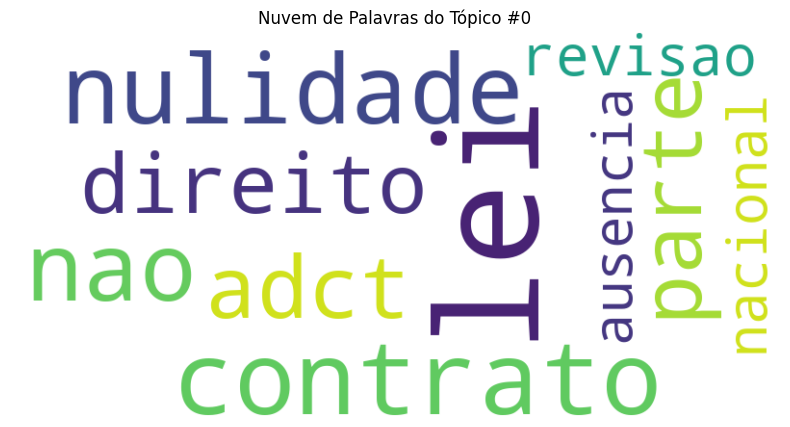

Tópico #1:
nao direito_consumidor recurso apelacao_civel consumidor indenizacao prova acao direito servico


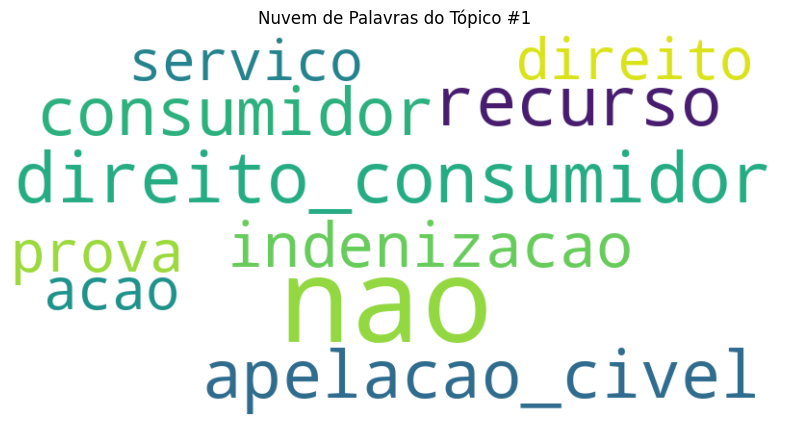

Tópico #2:
lei codigo_civil nao juros requisitos adct deve ausencia direito revogacao


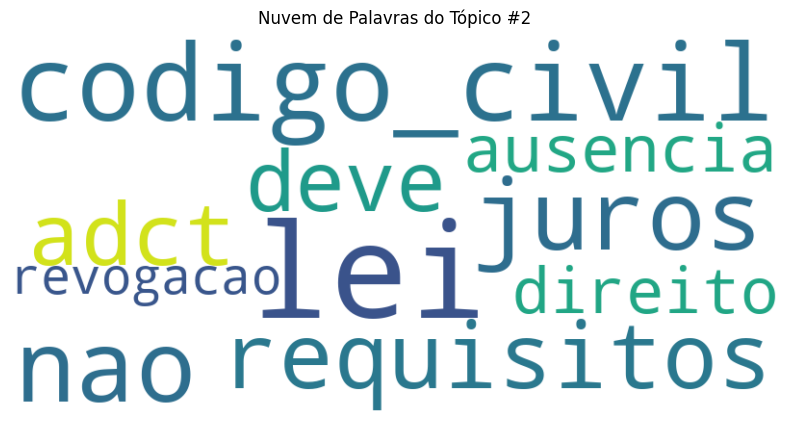

Tópico #3:
nao dano_moral contrato deve indenizacao danos_morais apelacao_civel direito_consumidor consumidor valor


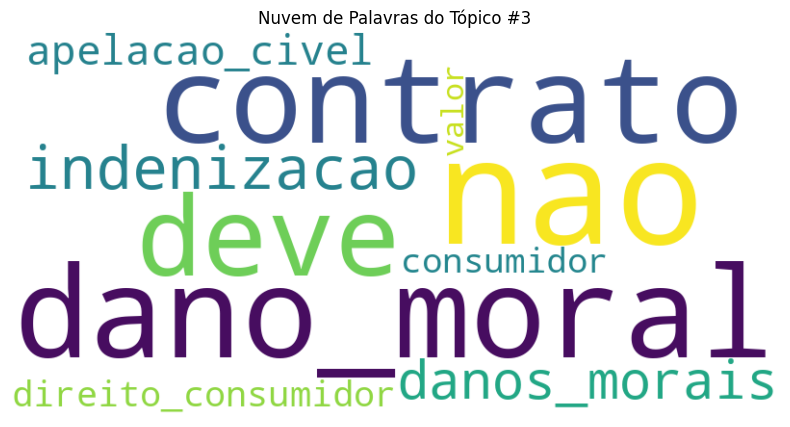

Tópico #4:
nao juros contrato credito consumidor direito_consumidor cobranca inexistencia apelacao_civel acao


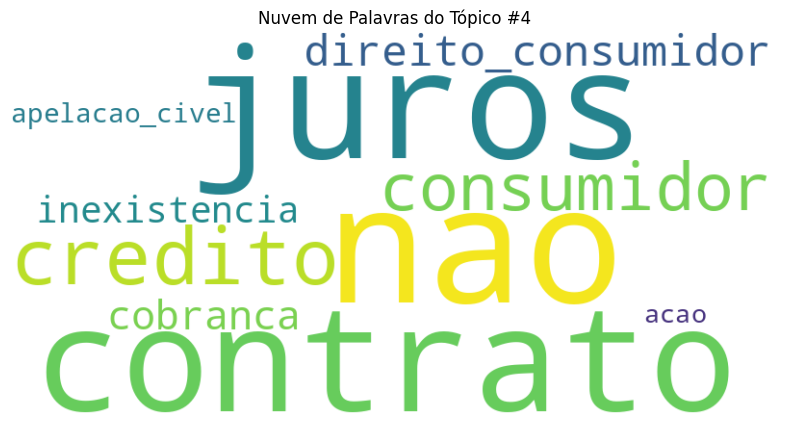

In [ ]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Criação de um dicionário de palavras e suas probabilidades para a nuvem de palavras
# Gerar nuvens de palavras para cada tópico
for topic_idx, topic in enumerate(lda.components_):
    print(f"Tópico #{topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-10 - 1:-1]]))

    # Criação de um dicionário de palavras e suas probabilidades para a nuvem de palavras
    word_freq = {words[i]: topic[i] for i in topic.argsort()[:-10 - 1:-1]}

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuvem de Palavras do Tópico #{topic_idx}")
    plt.show()

## 5.3 Visualização dos tópicos em clusters

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models.ldamodel import LdaModel

pyLDAvis.enable_notebook()

lda_model = LdaMulticore(corpus=ementasTokenizadasBoW,
                        id2word=dictionary,
                        num_topics=4,
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

vis = pyLDAvis.gensim_models.prepare(lda_model, ementasTokenizadasBoW, dictionary)

vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.075445  0.030781       1        1  28.900042
1     -0.147199  0.004893       2        1  27.306654
0      0.040982 -0.049393       3        1  22.256417
3      0.030772  0.013719       4        1  21.536887, topic_info=                             Term         Freq        Total Category  logprob  \
232                           lei  2567.000000  2567.000000  Default  30.0000   
1388                        juros  2355.000000  2355.000000  Default  29.0000   
1060                 codigo_civil  1759.000000  1759.000000  Default  28.0000   
4021                         adct  1182.000000  1182.000000  Default  27.0000   
2375                    revogacao   944.000000   944.000000  Default  26.0000   
1534               remuneratorios  1008.000000  1008.000000  Default  25.0000   
4038           sistema_financeiro   848.000000   848.000000  Default  24.0000   
1296                   requisitos  1431.000000  1431.000000  Default  23.0000   
857                      nacional   907.000000   907.000000  Default  22.0000   
309                    dano_moral  2157.000000  2157.000000  Default  21.0000   
1262                       tarifa   668.000000   668.000000  Default  20.0000   
346                         ainda  1018.000000  1018.000000  Default  19.0000   
598                 capitalizacao   739.000000   739.000000  Default  18.0000   
4045                    debatidas   446.000000   446.000000  Default  17.0000   
372                   indenizacao  2102.000000  2102.000000  Default  16.0000   
4051                    nulidades   426.000000   426.000000  Default  15.0000   
4060                    tribunais   489.000000   489.000000  Default  14.0000   
531                        debito   957.000000   957.000000  Default  13.0000   
764                      negocios   512.000000   512.000000  Default  12.0000   
1536                      revisao   789.000000   789.000000  Default  11.0000   
1322                          las   429.000000   429.000000  Default  10.0000   
1493                    encontrar   423.000000   423.000000  Default   9.0000   
748                     juridicos   523.000000   523.000000  Default   8.0000   
4049                       juizes   487.000000   487.000000  Default   7.0000   
4047                  fortalecido   466.000000   466.000000  Default   6.0000   
895                     cobertura   317.000000   317.000000  Default   5.0000   
4033                  nao_revogou   509.000000   509.000000  Default   4.0000   
4052                    permitido   433.000000   433.000000  Default   3.0000   
4061              turma_julgadora   441.000000   441.000000  Default   2.0000   
4044                     conhecer   462.000000   462.000000  Default   1.0000   
1081         ma_prestacao_servico   154.161851   174.979206   Topic1  -6.5490   
3074                    mostraram    21.465655    24.617064   Topic1  -8.5205   
1168                 intensamente    91.824360   105.681969   Topic1  -7.0671   
1489                 desconhecido    88.233776   102.772243   Topic1  -7.1070   
1163                       emerge    90.622252   105.643782   Topic1  -7.0803   
2658                     solicita    22.767310    26.572233   Topic1  -8.4617   
1617                 consolidacao   124.575067   146.019111   Topic1  -6.7621   
1169                    interfere    94.004107   110.503251   Topic1  -7.0436   
3413                        emite    14.154532    16.745411   Topic1  -8.9369   
1165                      fugindo    89.301150   105.710329   Topic1  -7.0950   
1142               experimentados   129.524607   153.559379   Topic1  -6.7231   
1626                 representada   125.436362   150.771975   Topic1  -6.7552   
3073               fonte_pagadora    21.179864    25.496604   Topic1  -8.5339   
9181                   oscilacoes    13.119758    15.844106   Topic1 

#6º Passo: Planilha de Acórdãos, Clusters e Similaridade textual

In [ ]:
df_ementas = pd.read_excel('/content/ementas_completas_clusters.xlsx', header=None)

# Definindo nomes de colunas
colunas = ['classe_processual', 'numero_processo', 'relator', 'datajulgamento', 'ementa', 'cluster']

df_ementas.columns = colunas

df_ementas.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



classe_processual            numero_processo                        relator  \
0    apelação cível  5015921.23.2022.8.13.0480           Valdez Leite Machado   
1    apelação cível  0011885.61.2019.8.13.0372  José Américo Martins Da Costa   
2    apelação cível  5002199.92.2017.8.13.0480  José Américo Martins Da Costa   
3    apelação cível  5002697.10.2021.8.13.0106  José Américo Martins Da Costa   
4    apelação cível  5006785.75.2019.8.13.0134  José Américo Martins Da Costa   

  datajulgamento  \
0     17/12/2023   
1     15/12/2023   
2     15/12/2023   
3     15/12/2023   
4     15/12/2023   

                                                                                                                                                                                                                                                                                                                                                                                                            ementa  \
0  apelação cível embargos à execução abertura de crédito rotativo súmula 233 do stj duplicatas liquidez certeza e exigibilidade demonstrativo da dívida prosseguimento da execução honorários advocatícios extrajudiciais ilegalidade da cobrança embargos à execução acolhidos parcialmente não se desincumbido do ônus de comprovar a ilegalidade inerente à execução em trâmite bem como a inobservância do...   
1  cível direito do consumidor ação de conhecimento ilegitimidade passiva teoria da asserção pretensão declaratória prescrição quinquenal descontos sobre benefício previdenciário nulidade cartão de crédito consignado negativa de contratação vício de consentimento erro substancial não verificação 1 a legitimidade refere se ao vínculo existente entre determinada parte e o resultado buscado com a aç...   
2  cível direito do consumidor ação de conhecimento pretensão declaratória nulidade cartão de crédito consignado negativa de contratação vício de consentimento erro substancial não verificação 1 a contratação de cartão de crédito consignado é autorizada no ordenamento jurídico brasileiro o que não impede a verificação de abusividades no caso concreto 2 deve ser declarada a nulidade do contrato de...   
3  apelação cível direito do consumidor ação de conhecimento pretensão indenizatória instalação de placas de energia solar defeito não comprovado revelia presunção relativa fatos constitutivos do autor ausência de indícios mínimos 1 tratando se de relação de consumo a responsabilidade do fornecedor é objetiva prescindindo da comprovação de culpa 2 o artigo 344 do cpc estabelece que em caso de rev...   
4  apelação cível direito do consumidor ação de conhecimento pretensão declaratória nulidade cartão de crédito consignado negativa de contratação vício de consentimento erro substancial não verificação 1 a contratação de cartão de crédito consignado é autorizada no ordenamento jurídico brasileiro o que não impede a verificação de abusividades no caso concreto 2 deve ser declarada a nulidade do co...   

   cluster  
0        2  
1        2  
2        2  
3       11  
4        2

In [ ]:
df_similarity_matrix = pd.read_csv('/content/similarity_matrix.csv')

df_similarity_matrix.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0         1         2         3         4         5         6  \
0  1.000000  0.219167  0.195056  0.159182  0.198582  0.195056  0.125881   
1  0.219167  1.000000  0.947299  0.198569  0.942695  0.947299  0.287716   
2  0.195056  0.947299  1.000000  0.165550  0.995474  1.000000  0.172807   
3  0.159182  0.198569  0.165550  1.000000  0.172227  0.165550  0.193577   
4  0.198582  0.942696  0.995474  0.172227  1.000000  0.995474  0.176618   

          7         8         9  ...      3153      3154      3155      3156  \
0  0.201453  0.126364  0.072544  ...  0.090559  0.076751  0.154698  0.342400   
1  0.933710  0.310245  0.151323  ...  0.135260  0.139181  0.137492  0.323133   
2  0.985529  0.304030  0.128935  ...  0.120066  0.124341  0.128244  0.270675   
3  0.173194  0.180153  0.304433  ...  0.147087  0.149649  0.115795  0.252903   
4  0.986953  0.298189  0.134741  ...  0.126071  0.128928  0.132767  0.274897   

       3157      3158      3159      3160      3161      3162  
0  0.256688  0.202409  0.161641  0.273983  0.167499  0.252740  
1  0.248133  0.244660  0.222106  0.354812  0.251889  0.283439  
2  0.207284  0.230912  0.220333  0.315808  0.199494  0.256723  
3  0.234469  0.111844  0.253411  0.201395  0.352618  0.174520  
4  0.210859  0.235675  0.228258  0.320178  0.203871  0.259907  

[5 rows x 3163 columns]

In [ ]:
# Função para inserir colunas de df2 em df1 em posições específicas
def adicionar_colunas(df1, df2, posicoes):
    for col, pos in zip(df2.columns, posicoes):
        df1.insert(loc=pos, column=col, value=df2[col])
    return df1

# Posições desejadas para as colunas de df2 em df1
posicoes = [0, 1, 2, 3]  # Coluna 'X' vai para posição 1, coluna 'Y' vai para posição 3

df_similarity_matrix = adicionar_colunas(df_similarity_matrix, df_ementas, posicoes)

df_similarity_matrix.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



classe_processual            numero_processo                        relator  \
0    apelação cível  5015921.23.2022.8.13.0480           Valdez Leite Machado   
1    apelação cível  0011885.61.2019.8.13.0372  José Américo Martins Da Costa   
2    apelação cível  5002199.92.2017.8.13.0480  José Américo Martins Da Costa   
3    apelação cível  5002697.10.2021.8.13.0106  José Américo Martins Da Costa   
4    apelação cível  5006785.75.2019.8.13.0134  José Américo Martins Da Costa   

  datajulgamento         0         1         2         3         4         5  \
0     17/12/2023  1.000000  0.219167  0.195056  0.159182  0.198582  0.195056   
1     15/12/2023  0.219167  1.000000  0.947299  0.198569  0.942695  0.947299   
2     15/12/2023  0.195056  0.947299  1.000000  0.165550  0.995474  1.000000   
3     15/12/2023  0.159182  0.198569  0.165550  1.000000  0.172227  0.165550   
4     15/12/2023  0.198582  0.942696  0.995474  0.172227  1.000000  0.995474   

   ...      3153      3154      3155      3156      3157      3158      3159  \
0  ...  0.090559  0.076751  0.154698  0.342400  0.256688  0.202409  0.161641   
1  ...  0.135260  0.139181  0.137492  0.323133  0.248133  0.244660  0.222106   
2  ...  0.120066  0.124341  0.128244  0.270675  0.207284  0.230912  0.220333   
3  ...  0.147087  0.149649  0.115795  0.252903  0.234469  0.111844  0.253411   
4  ...  0.126071  0.128928  0.132767  0.274897  0.210859  0.235675  0.228258   

       3160      3161      3162  
0  0.273983  0.167499  0.252740  
1  0.354812  0.251889  0.283439  
2  0.315808  0.199494  0.256723  
3  0.201395  0.352618  0.174520  
4  0.320178  0.203871  0.259907  

[5 rows x 3167 columns]

In [ ]:
df_similarity_matrix.to_excel('/content/similarity_matrix_ementas_cluster.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

